# 8.3 量化金融 - 股票涨跌预测模型搭建

# 8.3.1 多因子模型搭建

**1.引入之后需要用到的库**

In [1]:
import tushare as ts  # 股票基本数据相关库
import numpy as np  # 科学计算相关库
import pandas as pd  # 科学计算相关库  
import talib  # 股票衍生变量数据相关库
import matplotlib.pyplot as plt  # 引入绘图相关库
from sklearn.ensemble import RandomForestClassifier  # 引入分类决策树模型
from sklearn.metrics import accuracy_score  # 引入准确度评分函数
import warnings
warnings.filterwarnings("ignore") # 忽略警告信息，警告非报错，不影响代码执行

**2.股票数据处理与衍生变量生成**

我们这里将8.2节股票基本数据和股票衍生变量数据的相关代码汇总，方便之后的股票涨跌预测模型的搭建：

In [2]:
# 1.股票基本数据获取
df = ts.get_k_data('000002',start='2015-01-01',end='2019-12-31')
df = df.set_index('date')  # 设置日期为索引

# 2.简单衍生变量构造
df['close-open'] = (df['close'] - df['open'])/df['open']
df['high-low'] = (df['high'] - df['low'])/df['low']

df['pre_close'] = df['close'].shift(1)  # 该列所有往下移一行形成昨日收盘价
df['price_change'] = df['close']-df['pre_close']
df['p_change'] = (df['close']-df['pre_close'])/df['pre_close']*100

# 3.移动平均线相关数据构造
df['MA5'] = df['close'].rolling(5).mean()
df['MA10'] = df['close'].rolling(10).mean()
df.dropna(inplace=True)  # 删除空值

# 4.通过Ta_lib库构造衍生变量
df['RSI'] = talib.RSI(df['close'], timeperiod=12)  # 相对强弱指标
df['MOM'] = talib.MOM(df['close'], timeperiod=5)  # 动量指标
df['EMA12'] = talib.EMA(df['close'], timeperiod=12)  # 12日指数移动平均线
df['EMA26'] = talib.EMA(df['close'], timeperiod=26)  # 26日指数移动平均线
df['MACD'], df['MACDsignal'], df['MACDhist'] = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)  # MACD值
df.dropna(inplace=True)  # 删除空值

In [3]:
# 查看此时的df后五行
df.tail()

,open,close,high,low,volume,code,close-open,high-low,pre_close,price_change,p_change,MA5,MA10,RSI,MOM,EMA12,EMA26,MACD,MACDsignal,MACDhist
date,,,,,,,,,,,,,,,,,,,,
2019-12-25,30.40,30.29,30.63,30.18,685037.0,000002,-0.003618,0.014911,30.38,-0.09,-0.296248,30.878,30.075,63.075563,-0.02,29.908556,28.973211,0.935345,0.772958,0.162387
2019-12-26,30.50,31.12,31.30,30.50,888790.0,000002,0.020328,0.026230,30.29,0.83,2.740178,30.896,30.387,68.890164,0.09,30.094932,29.132233,0.962699,0.810906,0.151793
2019-12-27,31.23,31.00,31.32,30.81,703096.0,000002,-0.007365,0.016553,31.12,-0.12,-0.385604,30.760,30.672,67.220611,-0.68,30.234173,29.270586,0.963587,0.841442,0.122145
2019-12-30,31.35,31.57,31.79,31.02,915751.0,000002,0.007018,0.024823,31.00,0.57,1.838710,30.872,30.884,70.877814,0.56,30.439685,29.440913,0.998772,0.872908,0.125864
2019-12-31,31.35,32.18,32.45,31.32,663497.0,000002,0.026475,0.036079,31.57,0.61,1.932214,31.232,31.057,74.233951,1.80,30.707426,29.643808,1.063618,0.911050,0.152567


**3.特征变量和目标变量提取**

In [4]:
X = df[['close', 'volume', 'close-open', 'MA5', 'MA10', 'high-low', 'RSI', 'MOM', 'EMA12', 'MACD', 'MACDsignal', 'MACDhist']]
y = np.where(df['price_change'].shift(-1)> 0, 1, -1)

首先强调最核心的一点：应该是今天的股价信息预测下一天的股价涨跌情况，所以y应该是下一天的股价变化情况。

其中Numpy库中的where()函数的使用方法如下所示：
np.where(判断条件,满足条件的赋值,不满足条件的赋值)

其中df['price_change'].shift(-1)则是利用shift()函数将price_change（股价变化）这一列往上移动一行，这样就获得了每一行对应的下一天股价涨跌情况。

因此这里的判断条件就是下一天股价是否大于0，如果下一天股价涨了的我们则y赋值为数字1，下一天股价跌了的，则y赋值为数字-1。这个下一天的股价涨跌情况就是我们根据当天股票基本数据以及衍生变量预测的内容。

**3.训练集和测试集数据划分**

接下来，我们要将原始数据集进行分割，我们要注意到一点，训练集与测试集的划分要按照时间序列划分，而不是像之前利用train_test_split()函数进行划分。原因在于股票价格的变化趋势具有时间性，如果我们随机划分，则会破坏时间性特征，因为我们是根据当天数据来预测下一天的股价涨跌情况，而不是任意一天的股票数据来预测下一天的股价涨跌情况。
因此，我们将前90%的数据作为训练集，后10%的数据作为测试集，代码如下：

In [5]:
X_length = X.shape[0]  # shape属性获取X的行数和列数，shape[0]即表示行数 
split = int(X_length * 0.9)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

**4.模型搭建**

In [6]:
model = RandomForestClassifier(max_depth=3, n_estimators=10, min_samples_leaf=10, random_state=1)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

# 8.3.2 模型使用与评估

**1.预测下一天的涨跌情况**

In [7]:
y_pred = model.predict(X_test)
print(y_pred)

[-1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1
  1  1  1 -1  1 -1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [8]:
a = pd.DataFrame()  # 创建一个空DataFrame 
a['预测值'] = list(y_pred)
a['实际值'] = list(y_test)
a.head()

,预测值,实际值
0,-1,-1
1,-1,-1
2,-1,-1
3,-1,-1
4,1,1


In [9]:
# 查看预测概率
y_pred_proba = model.predict_proba(X_test)
y_pred_proba[0:5]

array([[0.51621099, 0.48378901],
       [0.51550336, 0.48449664],
       [0.5285002 , 0.4714998 ],
       [0.5096509 , 0.4903491 ],
       [0.47469396, 0.52530604]])

**2.模型准确度评估**

In [10]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
print(score)

0.580952380952381


In [11]:
# 此外，我们还可以通过模型自带的score()函数记性打分，代码如下：
model.score(X_test, y_test)

0.580952380952381

**3.分析数据特征的重要性**

In [12]:
model.feature_importances_

array([0.14523239, 0.09849436, 0.06155863, 0.0275968 , 0.05959848,
       0.10019223, 0.02030875, 0.19567289, 0.0664462 , 0.06374818,
       0.09227566, 0.06887541])

In [13]:
# 通过如下代码可以更好的展示特征及其特征重要性：
features = X.columns  
importances = model.feature_importances_
a = pd.DataFrame()
a['特征'] = features
a['特征重要性'] = importances
a = a.sort_values('特征重要性', ascending=False)
a

,特征,特征重要性
7,MOM,0.195673
0,close,0.145232
5,high-low,0.100192
1,volume,0.098494
10,MACDsignal,0.092276
11,MACDhist,0.068875
8,EMA12,0.066446
9,MACD,0.063748
2,close-open,0.061559
4,MA10,0.059598


# 8.3.3 参数调优

In [14]:
from sklearn.model_selection import GridSearchCV  # 网格搜索合适的超参数
# 指定分类器中参数的范围
parameters = {'n_estimators':[5, 10, 20], 'max_depth':[2, 3, 4, 5], 'min_samples_leaf':[5, 10, 20, 30]}
new_model = RandomForestClassifier(random_state=1)  # 构建分类器
grid_search = GridSearchCV(new_model, parameters, cv=6, scoring='accuracy')  # cv=6表示交叉验证6次，scoring='roc_auc'表示以ROC曲线的AUC评分作为模型评价准则, 默认为'accuracy', 即按准确度评分

In [15]:
grid_search.fit(X_train, y_train)  # 传入数据
grid_search.best_params_  # 输出参数的最优值

{'max_depth': 3, 'min_samples_leaf': 10, 'n_estimators': 10}

# 8.3.4 收益回测曲线绘制

In [16]:
X_test['prediction'] = model.predict(X_test)
X_test['p_change'] = (X_test['close'] - X_test['close'].shift(1)) / X_test['close'].shift(1)

X_test['origin'] = (X_test['p_change'] + 1).cumprod()
X_test['strategy'] = (X_test['prediction'].shift(1) * X_test['p_change'] + 1).cumprod()

X_test[['strategy', 'origin']].tail()

,strategy,origin
date,,
2019-12-25,1.396445,1.015761
2019-12-26,1.358180,1.043595
2019-12-27,1.363417,1.039571
2019-12-30,1.338347,1.058685
2019-12-31,1.312488,1.079142


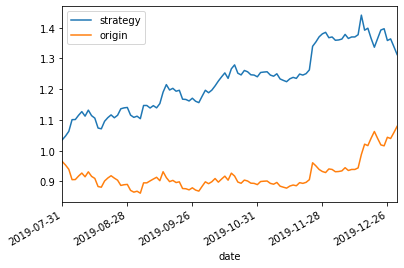

In [17]:
# 通过如下代码将收益情况删除空值后可视化，并设置X轴刻度自动倾斜：
X_test[['strategy', 'origin']].dropna().plot()
plt.gcf().autofmt_xdate()
plt.show()